# Notebook: Image Classification - Dog Breeds


### Description
This notebook is part of project **whatsthat.dog** which is website for identifying dog breed in a given image of a dog. The goal of this notebook is to export a trained model in .h5 (HDF5) format and additionally files for importing the model to JavaScript. 

### Datasets
The model will be trained using the following datasets:
- [ImageNet](http://image-net.org)
- [Stanford Dogs Dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/)

### Model
The initial plan is to use __NASNet model__ (https://arxiv.org/abs/1707.07012) pretrained with __ImageNet__ data and then modify the structure to have an additional dense layer and final classification layer (with nodes as many as dog breeds). Then the final model will be trained with the __Stanford Dogs Dataset__.


#### Let's start by defining all imports and global constants

In [93]:
%matplotlib inline
import re, time, os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import xml.etree.ElementTree as ET
from tqdm import tqdm, tqdm_notebook
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.applications import NASNetMobile
from tensorflow.python.keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau
from tensorflow.python.keras.layers import Dense, Dropout, Conv2D, MaxPool2D, BatchNormalization, GlobalAveragePooling2D


RANDOM_STATE = 20
NAME = f"dogs_breeds_{int(time.time())}"
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_CHANNELS = 3
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
INPUT_SHAPE = (*IMAGE_SIZE, IMAGE_CHANNELS)
BATCH_SIZE = 16
EPOCHS = 40

plt.style.use('ggplot')
np.random.seed(RANDOM_STATE)


## Preprocess data
Lets begin by processing the data. The dataset has following structure:
- Data
    - **Images**
        - Breed1
            - Image1
            - ...
            - ImageN
        - ...
        - Breed120
            - Image1
            - ...
            - ImageN
    - **Annotation**
        - Breed1
            - Annotation1
            - ...
            - AnnotationN
        - ...
        - Breed120
            - Annotation1
            - ...
            - AnnotationN

In [10]:
foldername_pattern = re.compile(r"n\d{8}-(.*)")

image_paths = []
annotation_paths = []
categories = []
category_names = {}

for index, folder in enumerate(os.listdir("data/Images")):
    
    category = foldername_pattern.search(folder).groups()[0]
    category_names[index] = category.replace("_", " ").capitalize()
    
    for item in os.listdir(f"data/Images/{folder}"):
        
        image_paths.append(f"data/Images/{folder}/{item}")
        annotation_paths.append(f"data/Annotation/{folder}/{item.split('.')[0]}")
        categories.append(index)
                                
df_input = pd.DataFrame({"image_file": image_paths, "annotation_file": annotation_paths, "category": categories})

A dataframe is now initialized which includes relative paths to all images and their annotations as well as to the respective label. Let's take a peek

In [11]:
df_input.head()

,image_file,annotation_file,category
0,data/Images/n02085620-Chihuahua/n02085620_1007...,data/Annotation/n02085620-Chihuahua/n02085620_...,0
1,data/Images/n02085620-Chihuahua/n02085620_1013...,data/Annotation/n02085620-Chihuahua/n02085620_...,0
2,data/Images/n02085620-Chihuahua/n02085620_1062...,data/Annotation/n02085620-Chihuahua/n02085620_...,0
3,data/Images/n02085620-Chihuahua/n02085620_1073...,data/Annotation/n02085620-Chihuahua/n02085620_...,0
4,data/Images/n02085620-Chihuahua/n02085620_1097...,data/Annotation/n02085620-Chihuahua/n02085620_...,0


In [12]:
df_input.tail()

,image_file,annotation_file,category
20575,data/Images/n02116738-African_hunting_dog/n021...,data/Annotation/n02116738-African_hunting_dog/...,119
20576,data/Images/n02116738-African_hunting_dog/n021...,data/Annotation/n02116738-African_hunting_dog/...,119
20577,data/Images/n02116738-African_hunting_dog/n021...,data/Annotation/n02116738-African_hunting_dog/...,119
20578,data/Images/n02116738-African_hunting_dog/n021...,data/Annotation/n02116738-African_hunting_dog/...,119
20579,data/Images/n02116738-African_hunting_dog/n021...,data/Annotation/n02116738-African_hunting_dog/...,119


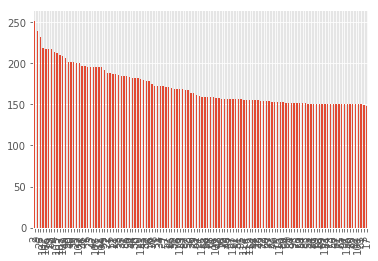

In [13]:
df_input["category"].value_counts().plot.bar();

In this case we can notice that the data is not distributed evenly

## Loading the data
The next step is to actually load in the data, normalize it and split it to train, validation and test data. Loading will be done using __Keras__ helper functions which utilizes the pillow library. 

For the data split I have chosen to include only 10% to the test data and 20% for validation and rest 70% for training.

In [79]:
df_input = df_input.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

X = []
y = []

for index, row in tqdm(df_input.iterrows(), total=len(df_input)):
    
    img = load_img(row["image_file"])
    annotation_tree = ET.parse(row["annotation_file"])
    bndbox = {i.tag : int(i.text) for i in annotation_tree.getroot()[5][4]}   
    img = img.crop((bndbox["xmin"],bndbox["ymin"], bndbox["xmax"], bndbox["ymax"]))
    img = img.resize(IMAGE_SIZE)
    
    X.append(img_to_array(img))
    y.append(row["category"])


X = np.array(X)
y = np.array(y)
X = X / 255.0

split_distribution = [int(0.7*len(X)), int(0.9*len(X))]
X_train, X_validation, X_test = np.split(X, split_distribution)
y_train, y_validation, y_test = np.split(y, split_distribution)

100%|██████████| 20580/20580 [01:22<00:00, 248.60it/s]


Now the data is ready for the training and the model can be defined

## Defining model
As mentioned at the beginning the model will be based on the __NASnet__ architecture and more in detail to the __Mobile__ variant. This is to increase performance especially if the model is eventually deployed to browser or mobile environment. One of the reasons also for using the NASnet is that Keras library includes the model already pretrained with ImageNet dataset. Next step is to define the model and compile it.

In [89]:
base_model = NASNetMobile(weights="imagenet", include_top=False, input_shape=INPUT_SHAPE)
for layer in base_model.layers:
    layer.trainable = False

In [91]:
model = Sequential()

model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation="relu"))
model.add(Dense(len(category_names), activation="softmax"))

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

Let's take a peek for the underlying architecture

In [92]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NASNet (Model)               (None, 7, 7, 1056)        4269716   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1056)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1082368   
_________________________________________________________________
dense_1 (Dense)              (None, 120)               123000    
Total params: 5,475,084
Trainable params: 1,205,368
Non-trainable params: 4,269,716
_________________________________________________________________


Now both the data and the model is ready, and the training can be started

## Training the model
To make training more smooth and allow analysis afterwards, callbacks are used, namely, Tensorboard, EarlyStopping and ReduceLROnPlateau. After defining these the training process can be started.

In [94]:
tensorboard_cb = TensorBoard(log_dir=f"logs/{NAME}")
earlystop_cb = EarlyStopping(patience=5)
reducelronplateau_cb = ReduceLROnPlateau(monitor="val_loss", patience=2, verbose=1, factor=0.5, min_lr=0.0000001)

In [98]:
model.fit(
    x=X_train, 
    y=y_train, 
    validation_data=(X_validation, y_validation), 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    callbacks=[tensorboard_cb, earlystop_cb, reducelronplateau_cb],
    verbose=2
)
model.save(f"models/{NAME}.h5", overwrite=True)

Train on 14405 samples, validate on 4117 samples
Epoch 1/40
 - 109s - loss: 0.2472 - acc: 0.9168 - val_loss: 0.5683 - val_acc: 0.8419
Epoch 2/40
 - 62s - loss: 0.2384 - acc: 0.9182 - val_loss: 0.5648 - val_acc: 0.8416
Epoch 3/40
 - 59s - loss: 0.2364 - acc: 0.9188 - val_loss: 0.5645 - val_acc: 0.8428
Epoch 4/40
 - 64s - loss: 0.2396 - acc: 0.9185 - val_loss: 0.5694 - val_acc: 0.8445
Epoch 5/40

Epoch 00005: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
 - 65s - loss: 0.2303 - acc: 0.9244 - val_loss: 0.5683 - val_acc: 0.8407
Epoch 6/40
 - 62s - loss: 0.2228 - acc: 0.9254 - val_loss: 0.5687 - val_acc: 0.8411
Epoch 7/40

Epoch 00007: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
 - 60s - loss: 0.2260 - acc: 0.9234 - val_loss: 0.5701 - val_acc: 0.8421
Epoch 8/40
 - 60s - loss: 0.2245 - acc: 0.9250 - val_loss: 0.5709 - val_acc: 0.8416


OSError: Unable to create file (unable to open file: name = 'models/dogs_breeds_1558010569.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 302)

## Scoring the model
After training the model is evaluated with the test set

In [99]:
score = model.evaluate(X_test, y_test)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

2058/2058 [==============================] - ETA: 9s - loss: 0.9446 - acc: 0.718 - ETA: 9s - loss: 0.7138 - acc: 0.796 - ETA: 8s - loss: 0.6766 - acc: 0.833 - ETA: 8s - loss: 0.6589 - acc: 0.828 - ETA: 8s - loss: 0.5623 - acc: 0.843 - ETA: 8s - loss: 0.5488 - acc: 0.838 - ETA: 8s - loss: 0.5297 - acc: 0.834 - ETA: 8s - loss: 0.6015 - acc: 0.820 - ETA: 8s - loss: 0.6089 - acc: 0.826 - ETA: 7s - loss: 0.6234 - acc: 0.828 - ETA: 7s - loss: 0.5954 - acc: 0.835 - ETA: 7s - loss: 0.5754 - acc: 0.838 - ETA: 7s - loss: 0.5950 - acc: 0.836 - ETA: 7s - loss: 0.5835 - acc: 0.839 - ETA: 7s - loss: 0.5854 - acc: 0.841 - ETA: 6s - loss: 0.6116 - acc: 0.839 - ETA: 6s - loss: 0.6189 - acc: 0.840 - ETA: 6s - loss: 0.6089 - acc: 0.843 - ETA: 6s - loss: 0.6081 - acc: 0.845 - ETA: 6s - loss: 0.5973 - acc: 0.843 - ETA: 6s - loss: 0.6105 - acc: 0.837 - ETA: 6s - loss: 0.6486 - acc: 0.833 - ETA: 6s - loss: 0.6391 - acc: 0.837 - ETA: 5s - loss: 0.6305 - acc: 0.838 - ETA: 5s - loss: 0.6239 - acc: 0.838 - ETA: 